# Project initialization

## Importing libraries

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

## Importing data

In [190]:
# coffee beans in a certain coffe store
df = pd.read_csv("data/coffeebeans.csv", parse_dates=["Harvest.Year"])

## Cleaning the dataset

In [191]:
# change column names '.' to '_'
df.columns = df.columns.str.replace('.', '_')

# change feet to meter (all altitudes are already converted to meter, the unit was not corrected)
df["unit_of_measurement"] = 'm'

# fix wrong altitude values
df.iloc[543, 41:44] = 1100.0
df.iloc[896, 41:44] = 1901.64
df.iloc[1144, 41:44] = 1901.64
df.iloc[1040, 41:44] = 1100.0

# convert harvest year to dates (some dates are in weird format, these will be lost during conversion)
df["Harvest_Year"] = pd.to_datetime(df["Harvest_Year"], errors="coerce")

# use grading dates for missing harvest years as these are pretty close to the harvest year
df["Harvest_Year"].fillna(df["Grading_Date"], inplace=True)

# only keep Year from the timestamp
df["Harvest_Year"] = df["Harvest_Year"].dt.strftime("%Y")

# replace country names
countries = ["Tanzania, United Republic Of", "United States (Hawaii)", "United States (Puerto Rico)"]
countries_new = ["Tanzania", "Hawaii", "Puerto Rico"]

for c, cn in zip(countries, countries_new):
    df = df.replace(to_replace=c, value=cn)
    
# drop values with missing tcp rating
df = df[df["Total_Cup_Points"] > 0]


C:\Users\Marci\AppData\Local\Temp\ipykernel_3884\3168127510.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '_')


## Number of coffee bean types per country

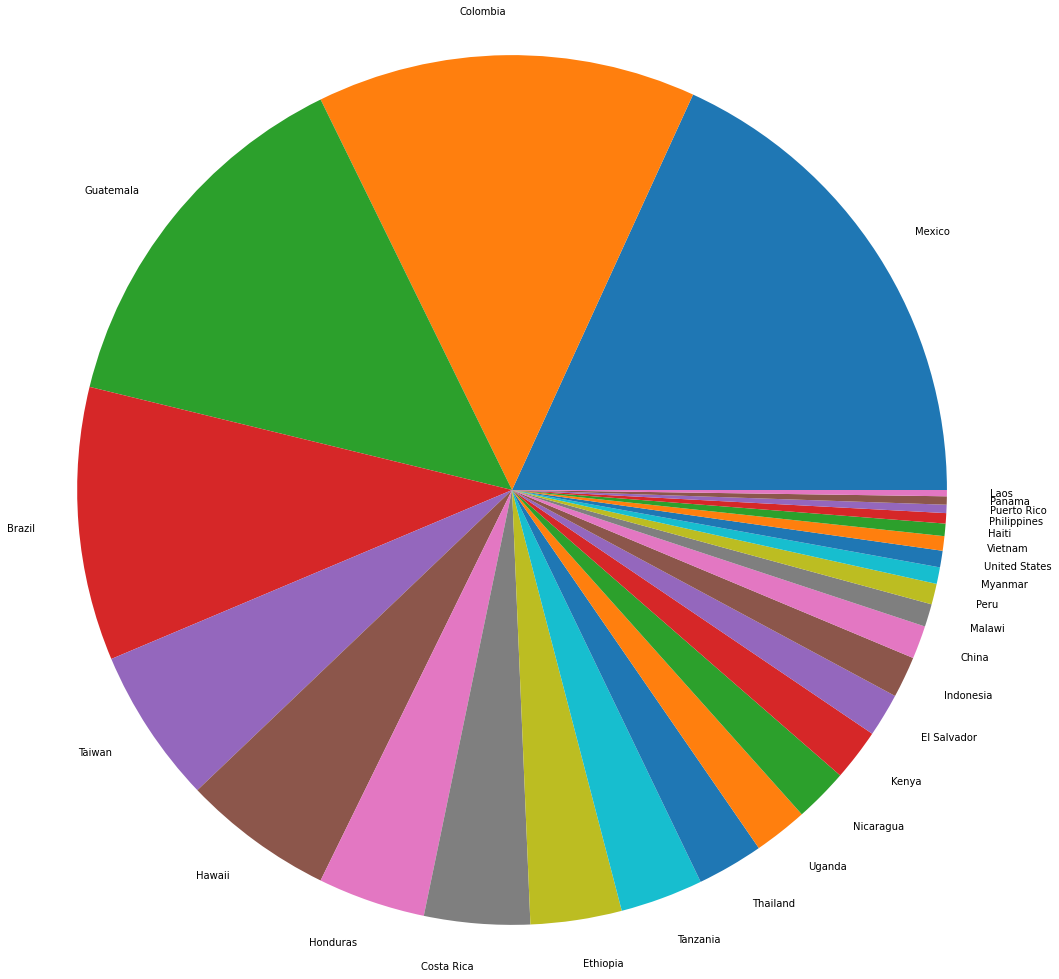

In [4]:
coffee_per_country = df.groupby(["Country_of_Origin"]).count()

# only show countries that have more than one coffee bean type
coffee_per_country = coffee_per_country[~(coffee_per_country["Species"] <= 2)]
coffee_per_country_sorted = coffee_per_country.sort_values(by="Species", ascending=False)

plt.figure(figsize=(10,10))
plt.pie(coffee_per_country_sorted["Species"], radius=2, labels=coffee_per_country_sorted.index)
plt.show()

## Average rating of coffee beans by year

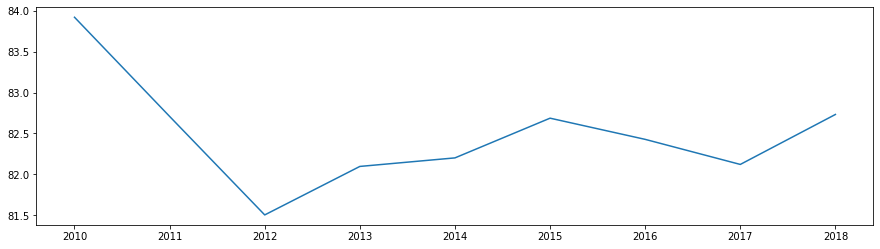

In [5]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

plt.figure(figsize=(15,4))
plt.plot(rating_per_year.index, rating_per_year["Total_Cup_Points"])
plt.show()

## Average rating of coffee beans by year on interpolated spline chart

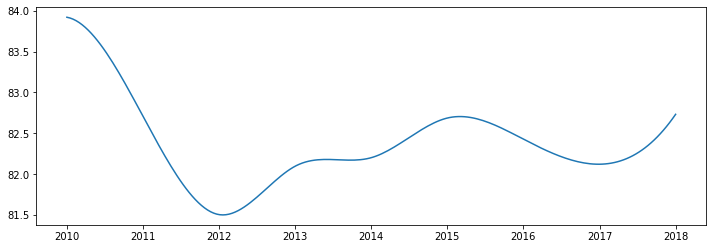

In [6]:
rating_per_year = df.groupby(["Harvest_Year"]).mean()

x = np.array(rating_per_year.index)
y = np.array(rating_per_year["Total_Cup_Points"])

#define x as 200 equally spaced values between the min and max of original x 
xnew = np.linspace(float(x.min()), float(x.max()), 200) 

#define spline
spl = make_interp_spline(x, y, k=3)
y_smooth = spl(xnew)

#create smooth line chart 
plt.figure(figsize=(12,4))
plt.plot(xnew, y_smooth)
plt.show()

## Average rating of coffee beans by year per country

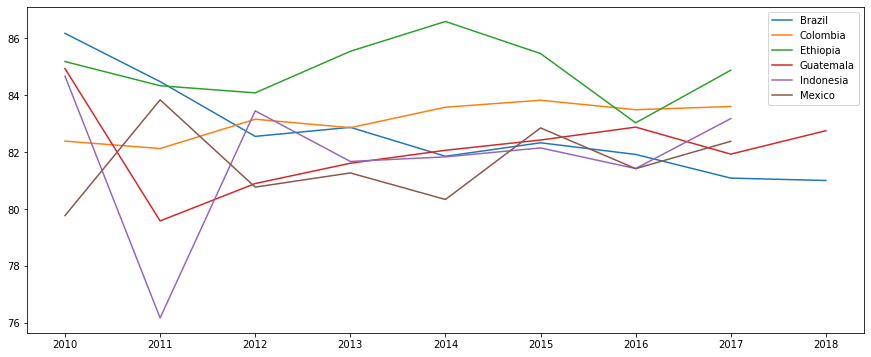

In [7]:
rating_per_year_country = df.groupby(["Harvest_Year", "Country_of_Origin"])["Total_Cup_Points"].mean().unstack()

# only create plot for countries with at least 8 ratings
rating_per_year_country = rating_per_year_country.loc[:,rating_per_year_country.notna().sum(0) >= 8]

plt.figure(figsize=(15,6))
plt.plot(rating_per_year_country.index, rating_per_year_country.values)
plt.legend(rating_per_year_country.columns,loc="best")
plt.show()

## Average rating of coffee beans per country

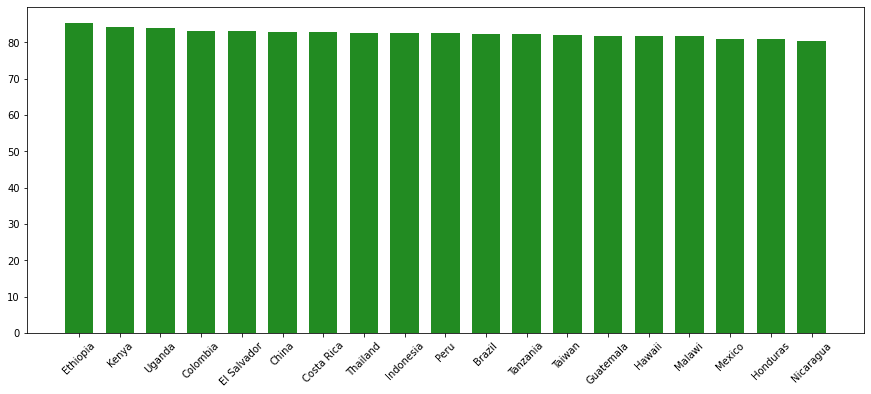

In [8]:
rating_per_country = df.groupby("Country_of_Origin").agg(count=("Country_of_Origin", "size"), mean=("Total_Cup_Points", "mean")).reset_index()
rating_per_country = rating_per_country[rating_per_country["count"] >= 10]
rating_per_country = rating_per_country.sort_values(by="mean", ascending=False)
c = ["forestgreen"]

plt.figure(figsize=(15,6))
plt.xticks(rotation=45)
plt.bar(rating_per_country["Country_of_Origin"], rating_per_country["mean"], width=0.7, color=c)
plt.show()

## Coffee bean producing region elevations per country

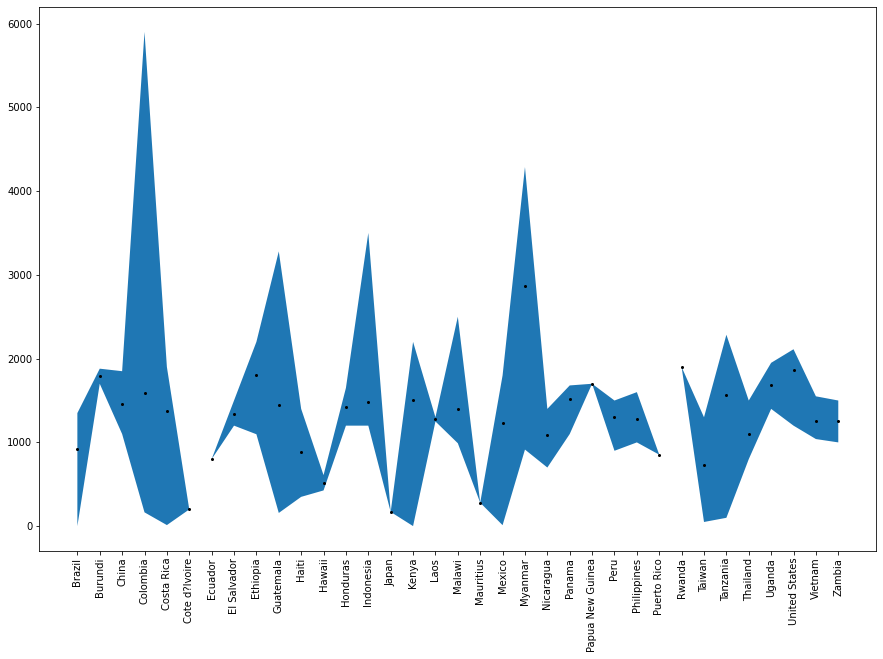

In [175]:
# drop rows that have no altitude data
df = df.dropna(subset=["altitude_mean_meters"])

# get lowest and highest elevation of coffee producing region per country
country_minimum_alt = df.groupby(["Country_of_Origin"])["altitude_low_meters"].min()
country_maximum_alt = df.groupby(["Country_of_Origin"])["altitude_high_meters"].max()

# get the average for each country by averaging their regional averages
country_mean_alt = df.groupby(["Country_of_Origin"])["altitude_mean_meters"].mean()

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
plt.fill_between(country_minimum_alt.index, country_minimum_alt.values, country_maximum_alt.values)
plt.scatter(country_mean_alt.index, country_mean_alt.values, color="black", s=4)
plt.show()

## Average rating of coffee beans per elevation

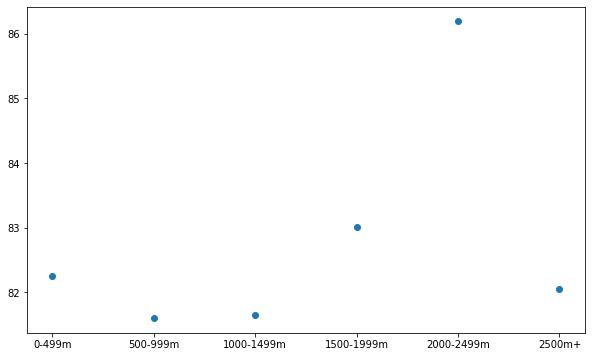

In [270]:
def check_elevation(x):
    if x < 500:
       return elevation_list[0]
    elif 500 <= x < 1000:
       return elevation_list[1]
    elif 1000 <= x < 1500:
       return elevation_list[2]
    elif 1500 <= x < 2000:
       return elevation_list[3]
    elif 2000 <= x < 2500:
       return elevation_list[4]
    else:
       return elevation_list[5]

df["elevation_group"] = df["altitude_mean_meters"].apply(check_elevation)
rating_per_elevation = df.groupby(["elevation_group"])["Total_Cup_Points"].mean()

elevation_list = ["0-499m", "500-999m", "1000-1499m", "1500-1999m", "2000-2499m", "2500m+"]
rating_per_elevation = rating_per_elevation.reindex(elevation_list)

plt.figure(figsize=(10,6))
plt.scatter(rating_per_elevation.index, rating_per_elevation.values)

## Average rating per elevation per country

In [263]:
df

Unnamed: 0  Species                       Owner Country_of_Origin  \
0              1  Arabica                   metad plc          Ethiopia   
1              2  Arabica                   metad plc          Ethiopia   
2              3  Arabica    grounds for health admin         Guatemala   
3              4  Arabica         yidnekachew dabessa          Ethiopia   
4              5  Arabica                   metad plc          Ethiopia   
...          ...      ...                         ...               ...   
1305        1306  Arabica                     cadexsa          Honduras   
1306        1307  Arabica    juan carlos garcia lopez            Mexico   
1307        1308  Arabica     myriam kaplan-pasternak             Haiti   
1308        1309  Arabica  exportadora atlantic, s.a.         Nicaragua   
1309        1310  Arabica   juan luis alvarado romero         Guatemala   

                                     Farm_Name                  Lot_Number  \
0                                    metad plc                         NaN   
1                                    metad plc                         NaN   
2     san marcos barrancas "san cristobal cuch                         NaN   
3        yidnekachew dabessa coffee plantation                         NaN   
4                                    metad plc                         NaN   
...                                        ...                         ...   
1305                               cerro bueno                         NaN   
1306                             el centenario                         NaN   
1307                                 200 farms                         NaN   
1308                          finca las marías  017-053-0211/ 017-053-0212   
1309                            finca el limon                         NaN   

                                                   Mill  \
0                                             metad plc   
1                                             metad plc   
2                                                   NaN   
3                                               wolensu   
4                                             metad plc   
...                                                 ...   
1305                                            cadexsa   
1306  la esperanza, municipio juchique de ferrer, ve...   
1307        coeb koperativ ekselsyo basen (350 members)   
1308                         beneficio atlantic condega   
1309                                   beneficio serben   

                      ICO_Number                                Company  \
0                      2014/2015      metad agricultural developmet plc   
1                      2014/2015      metad agricultural developmet plc   
2                            NaN                                    NaN   
3                            NaN  yidnekachew debessa coffee plantation   
4                      2014/2015      metad agricultural developmet plc   
...                          ...                                    ...   
1305                   13-63-174                                cadexsa   
1306                  1104328663                              terra mia   
1307                         NaN                           haiti coffee   
1308  017-053-0211/ 017-053-0212               exportadora atlantic s.a   
1309                  11/853/165                                unicafe   

           Altitude  ... Category_Two_Defects            Expiration  \
0         1950-2200  ...                    0       April 3rd, 2016   
1         1950-2200  ...                    1       April 3rd, 2016   
2     1600 - 1800 m  ...                    0        May 31st, 2011   
3         1800-2200  ...                    2      March 25th, 2016   
4         1950-2200  ...                    2       April 3rd, 2016   
...             ...  ...                  ...                   ...   
1305      1450 msnm  ...                    4        May 15th